## Мультиклассовая классификация изображений с pyTorch Lightning

Исходники
<a href='https://colab.research.google.com/drive/1VZJ8WeCLXIg565Gy1oloyBJvGELM7IVv'>Ноутбук</a>
<a href='https://youtu.be/fyQ6vk2AeXE'>Воркшоп</a>

### Download data

In [1]:
!kaggle datasets download -d "jehanbhathena/weather-dataset" -p ../weather_recognition_pytorch_lightning

100%|███████████████████████████████████████▉| 586M/587M [00:54<00:00, 10.4MB/s]
100%|████████████████████████████████████████| 587M/587M [00:54<00:00, 11.2MB/s]


In [2]:
import os
for dirname, _, filenames in os.walk('../weather_recognition_pytorch_lightning'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../weather_recognition_pytorch_lightning/weather-dataset.zip
../weather_recognition_pytorch_lightning/weather_recognition_pytorch_lightning.ipynb


In [3]:
%%capture
!unzip ../weather_recognition_pytorch_lightning/weather-dataset.zip -d ../weather_recognition_pytorch_lightning/

In [4]:
#!rm ../input/weather_recognition_pytorch_lightning/weather-dataset.zip

### Install libraries

In [5]:
!pip install -q split-folders pytorch_lightning==2.0.0 efficientnet_pytorch

In [6]:
# как решить проблему с установкой на старые версии MacOS
# https://forum.opencv.org/t/cannot-pip-install-opencv-4-5-4-on-macos-mojave/9901
# !pip install opencv-python==4.4.0.46

# если не помогло набираем команду в терминале
# !conda install -c fastai opencv-python-headless

In [7]:
# библиотеки для работы с изображениями
# import cv2
from PIL import Image
import numpy as np
# библиотека для работы с путями
from pathlib import Path
# вспомогательные
import matplotlib.pyplot as plt

# для работы
import torch
import torch.nn as nn
import torch.nn.functional as F
import splitfolders
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from torchmetrics import Accuracy
from efficientnet_pytorch import EfficientNet


# автоматическое логивароение результатов
from pytorch_lightning.loggers import TensorBoardLogger
# сохранение весов
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
# автоматическое отслеживание lr
from pytorch_lightning.callbacks import LearningRateMonitor
# ранние остановки
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

# дополнительные импорты
from tqdm.autonotebook import tqdm
from sklearn.metrics import classification_report
import warnings


# сахар опционально :)
SEED = 42
pl.seed_everything(SEED)
warnings.filterwarnings("ignore")

Global seed set to 42


In [8]:
DATASET = Path('../weather_recognition_pytorch_lightning/dataset')

In [9]:
# пробегаем по директории с картинками и добавляем в список
images = [p.resolve() for p in DATASET.glob("**/*") if p.suffix in {".png", ".jpg", ".jpeg"}]

In [10]:
images[:3]

[PosixPath('/Users/mitya/PycharmProjects/study/ds/ANN/Neural_Networks_and_CV/weather_recognition_pytorch_lightning/dataset/lightning/2100.jpg'),
 PosixPath('/Users/mitya/PycharmProjects/study/ds/ANN/Neural_Networks_and_CV/weather_recognition_pytorch_lightning/dataset/lightning/2114.jpg'),
 PosixPath('/Users/mitya/PycharmProjects/study/ds/ANN/Neural_Networks_and_CV/weather_recognition_pytorch_lightning/dataset/lightning/2128.jpg')]

In [11]:
len(images)

6862

In [12]:
sample_idx = np.random.randint(len(images))
sample_idx

860

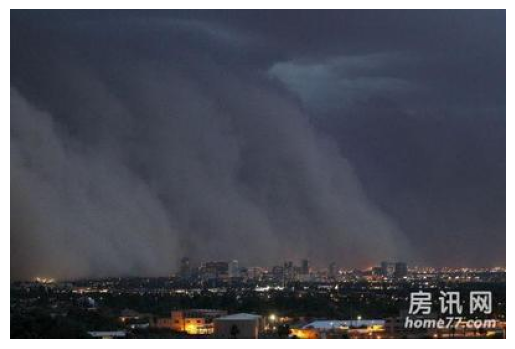

In [13]:
img = Image.open(images[sample_idx]) # RGB!
plt.imshow(img)
plt.axis("off")
plt.show()

In [123]:
img = cv2.imread(str(images[sample_idx])) # BGR!
plt.imshow(img[...,::-1]) # BGR -> RGB
plt.axis("off")
plt.show()

NameError: name 'cv2' is not defined

### Data preparation

In [15]:
splitfolders.ratio(
                    DATASET,
                    output="../weather_recognition_pytorch_lightning/weather_split",
                    seed=42,
                    ratio=(.8, .1, .1),
                    group_prefix=None,
                    move=False
)

Copying files: 6862 files [00:08, 783.57 files/s] 


In [16]:
images = [p.resolve() for p in Path("../weather_recognition_pytorch_lightning/weather_split/train").glob("**/*") if p.suffix in {".png", ".jpg", ".jpeg"}]
len(images)

5484

### Datamodule for download data

In [19]:
'''
Определяем класс ImgDataModule, который является подклассом pl.LightningDataModule.
Он используется для подготовки данных для обучения модели.
'''

class ImgDataModule(pl.LightningDataModule):
    '''
    В конструкторе класса __init__ задаются параметры, такие как размер пакета (batch_size),
    преобразования данных для обучающего и валидационного наборов (train_transform и val_transform)
    и путь к корневой директории изображений (img_root).
    '''
    def __init__(self,
                   batch_size = 1,
                   train_transform=None,
                   val_transform=None,
                   img_root = "../weather_recognition_pytorch_lightning/weather_split"
                   ):
        '''
        super().__init__() вызывает инициализацию родительского класса pl.LightningDataModule.
        Это важно, потому что ImgDataModule является подклассом pl.LightningDataModule
        и наследует его свойства и методы.
        Вызывая super().__init__(), мы гарантируем правильную инициализацию родительского класса и его состояния.
        '''
        super().__init__()
        '''
        Cохраняем значений аргументов, переданных в конструктор класса ImgDataModule,
        во внутренние переменные класса. Каждая строка кода присваивает соответствующему
        атрибуту класса значение, переданное в конструктор.
        '''
        self.batch_size = batch_size
        self.train_transform = train_transform
        self.val_transform = val_transform
        self.img_root = img_root

    '''
    Метод setup инициализирует наборы данных для обучения, валидации и тестирования.
    Он использует класс ImageFolder из библиотеки TorchVision для загрузки данных из
    указанных папок. Преобразования данных transform применяются к каждому изображению при загрузке.
    '''
    def setup(self, stage=None):
        self.train_set = ImageFolder(self.img_root / Path("train"), transform=self.train_transform)
        self.val_set = ImageFolder(self.img_root / Path("val"), transform=self.val_transform)
        self.test_set = ImageFolder(self.img_root / Path("test"), transform=self.val_transform)

    '''
    Метод train_dataloader создает загрузчик данных (DataLoader) для обучающего набора.
    Он возвращает загрузчик с указанным размером пакета (batch_size),
    случайным перемешиванием данных (shuffle=True) и двумя рабочими процессами (num_workers=2),
    которые будут использоваться для параллельной загрузки данных.
    '''
    def train_dataloader(self):
        return DataLoader(self.train_set, batch_size=self.batch_size, shuffle=True, num_workers=2)

    def val_dataloader(self):
        return DataLoader(self.val_set, batch_size=self.batch_size, shuffle=False, num_workers=2)

    def test_dataloader(self):
        return DataLoader(self.test_set, batch_size=self.batch_size, shuffle=False, num_workers=2)

    '''
    В итоге, класс ImgDataModule предоставляет удобный способ организации и загрузки данных
    для обучения, валидации и тестирования модели. Он использует классы ImageFolder и
    DataLoader для работы с изображениями и создания загрузчиков данных.
    '''

In [20]:
'''
Cоздаем экземпляр класса ImgDataModule и вызывает его метод setup().
- Создание экземпляра класса ImgDataModule() создает объект model,
  основанный на определении класса ImgDataModule.
- Вызов метода model.setup() инициализирует объект model и настраивает
  его для использования в качестве модуля данных.
'''

dm = ImgDataModule()
dm.setup()

In [21]:
data_classes = {k:v for k, v in enumerate(dm.test_set.classes)}
data_classes

{0: 'dew',
 1: 'fogsmog',
 2: 'frost',
 3: 'glaze',
 4: 'hail',
 5: 'lightning',
 6: 'rain',
 7: 'rainbow',
 8: 'rime',
 9: 'sandstorm',
 10: 'snow'}

### Create PyTorch Lightning Model

In [25]:
'''
Объявляем класс EffNetClassifier, который наследуется от pl.LightningModule.
'''
class EffNetClassifier(pl.LightningModule):
    '''
    Метод __init__ инициализирует объект класса EffNetClassifier и принимает следующие аргументы:
     - model - модель EfficientNet для использования
     - in_channels - количество каналов входных изображений
     - out_classes - количество классов для классификации
     - eta - скорость обучения (learning rate)
     - **kwargs - позволяет принимать произвольное количество именованных
       аргументов EffNetClassifier, которые не были определены явно.

    super().__init__() вызывает конструктор родительского класса pl.LightningModule.

    Далее создаем и сохраняем внутренние переменные:
     - self.save_hyperparameters() сохраняет гиперпараметры внутри класса.
     - self.model создает экземпляр модели EfficientNet с предварительно обученными весами.
     - device определяет устройство, на котором будет выполняться модель (GPU или CPU).
     - self.out_classes сохраняет количество классов.
     - self.criterion определяет функцию потерь (loss function) - кросс-энтропию.
     - self.metrics определяет метрику для оценки модели - точность (accuracy).
     - self.preds_stage инициализирует словарь для сохранения значений потерь и точности на разных этапах обучения.
    '''
    def __init__(self,
                 model = "efficientnet-b0",
                 in_channels = 3,
                 out_classes = 11,
                 eta = 3e-4,
                 **kwargs
                 ):
        super().__init__()
        self.save_hyperparameters()
        self.model = EfficientNet.from_pretrained(model,
                                                  num_classes = out_classes,
                                                  in_channels = in_channels)
        device = "cuda" if torch.cuda.is_available() else "cpu"
        self.out_classes = out_classes
        self.criterion = nn.CrossEntropyLoss()
        self.metrics = {"accuracy": Accuracy(task="multiclass", num_classes=out_classes).to(device)}
        self.preds_stage = {"train":{"probability":[], "loss": [], "accuracy":[]},
                            "valid":{"probability":[], "loss": [], "accuracy":[]},
                            "test":{"probability":[], "loss": [], "accuracy":[]}}

    # Метод forward определяет прямой проход модели и возвращает выход модели.
    def forward(self, x):
        return self.model(x)

    '''
    Метод shared_step обрабатывает одну пакетную выборку (batch) и выполняет следующие действия:
     - Разделяет входные данные и метки классов из пакетной выборки
     - Вычисляет логиты (сырые предсказания) с помощью метода forward
     - Применяет функцию softmax к логитам для получения вероятностей
     - Применяет функцию argmax для получения предсказанных классов
     - Вычисляет значение функции потерь на основе логитов и меток классов
     - Сохраняет вероятность, потерю и точность в словаре preds_stage для соответствующего этапа (train/valid/test)
     - Возвращает вероятности, предсказанные классы и значение потери
    '''
    def shared_step(self,
                  sample,
                  stage):
        x, y = sample
        logits = self.forward(x.to(torch.float32))
        sm = nn.Softmax(dim=1)
        probs = sm(logits)
        preds = torch.argmax(logits, 1)
        loss = self.criterion(logits, y.to(torch.int64))
        self.preds_stage[stage]['probability'].append(probs)
        self.preds_stage[stage]['loss'].append(loss.detach().cpu())
        self.preds_stage[stage]['accuracy'].append(self.metrics["accuracy"](preds, y).detach().cpu())
        return loss

    '''
    Метод shared_epoch_end выполняется в конце эпохи и выполняет следующие действия:
     - Извлекает потери и точность из словаря preds_stage для соответствующего этапа (train/valid/test)
     - Преобразует значения потерь и точности в тензоры, вычисляет их среднее значение
     - Создает словарь с метриками для записи в журнал
     - Использует self.log_dict для записи метрик в журнал и отображения на прогресс-баре
     - Очищает списки потерь и точности для следующей эпохи
    '''
    def shared_epoch_end(self,
                       stage):
        loss = self.preds_stage[stage]['loss']
        loss = torch.stack(loss)
        loss = np.mean([x.item() for x in loss])

        acc = self.preds_stage[stage]['accuracy']
        acc = torch.stack(acc)
        acc = np.mean([x.item() for x in acc])

        metrics = {

            f"{stage}_loss": loss,
            f"{stage}_acc": acc
        }

        self.log_dict(metrics, prog_bar=True)
        self.preds_stage[stage]['loss'].clear()
        self.preds_stage[stage]['accuracy'].clear()

    '''
    Метод configure_optimizers определяет оптимизатор и планировщик скорости обучения.
    Создается оптимизатор SGD, который оптимизирует параметры модели с заданной скоростью обучения.
    Метод возвращает словарь с оптимизатором и планировщиком скорости обучения.
    '''
    def configure_optimizers(self):
        optimizer = torch.optim.SGD(
            self.parameters(),
            lr = self.hparams.eta
        )

        '''
        Создается словарь scheduler_dict, который определяет планировщик скорости
        обучения для управления скоростью обучения на основе заданных критериев.
        patience — если через n эпох не произошло изменения метрики снижаем значение параметра,
        в нашем случае learning rate.
        '''
        scheduler_dict = {
            "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer,
                patience=3
            ),
            "interval": "epoch",
            "monitor": "valid_loss"
        }

        return {"optimizer": optimizer, "lr_scheduler": scheduler_dict}

    '''
    Методы training_step, validation_step, test_step выполняют общий шаг
    обработки пакетной выборки для соответствующих этапов (train/valid/test).
    Они вызывают метод shared_step, передавая ему пакетную выборку и имя этапа.
    Методы on_training_epoch_end, on_validation_epoch_end, on_test_epoch_end
    выполняют общую обработку в конце эпохи для соответствующих этапов (train/valid/test).
    Они вызывают метод shared_epoch_end, передавая ему имя этапа.
    '''
    def training_step(self,
                    batch,
                    batch_idx):
        return self.shared_step(batch, "train")

    def on_training_epoch_end(self):
        return self.shared_epoch_end("train")

    def validation_step(self,
                    batch,
                    batch_idx):
        return self.shared_step(batch, "valid")

    def on_validation_epoch_end(self):
        return self.shared_epoch_end("valid")

    def test_step(self,
                    batch,
                    batch_idx):
        return self.shared_step(batch, "test")

    def on_test_epoch_end(self):
        return self.shared_epoch_end("test")

### Стандартизация

In [26]:
'''
Cоздаем объект transform_train типа Compose из модуля transforms библиотеки PyTorch.
Compose позволяет объединять несколько преобразований, которые могут быть применены к входным данным.

В данном случае, список преобразований содержит следующие операции:
- Resize((224, 224)): Изменяет размер изображения до указанных размеров (224x224 пикселей).
- RandomHorizontalFlip(p=.5): Случайным образом отражает изображение по горизонтали с вероятностью 0.5.
- ToTensor(): Преобразует изображение в тензор формата torch.Tensor.
- Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
  Нормализует значения тензора изображения с помощью указанных средних и стандартных отклонений
  для каждого из каналов.

Таким образом, transform_train представляет собой последовательность преобразований,
которые могут быть применены к обучающему набору данных для подготовки его к обучению модели.

Каждый раз при создании  нового батча операция RandomHorizontalFlip будет
преобразовывать каждое изображение в обучающем наборе с вероятностью 0.5, что в итоге
увеличит исходный датасет

https://stackoverflow.com/questions/51677788/data-augmentation-in-pytorch
'''
transform_train = transforms.Compose(

                [transforms.Resize((224, 224)),
                 transforms.RandomHorizontalFlip(p=.5),
                 transforms.ToTensor(),
                 transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

                 ]

)

# трансформации для валидации и теста
# (оставляем только ресайз, тензор и нормализацию)
transform_test = transforms.Compose(

                [transforms.Resize((224, 224)),
                 transforms.ToTensor(),
                 transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

                 ]

)

### Обучение

In [27]:
BATCH = 16
# создаем DataModule-экземпляр
dm = ImgDataModule(BATCH, transform_train, transform_test)
EXPERIMENT = "efficientnet-b0"
ETA = 3*10e-3
model = EffNetClassifier(eta=ETA, model=EXPERIMENT)
# список для отслеживания lr, ранних остановок, сохранения весов
callbacks = [

            ModelCheckpoint(

                dirpath='../weather_recognition_pytorch_lightning/models',
                filename='{epoch}_{valid_acc:.2f}_{valid_loss:.2f}',
                save_top_k=5,
                monitor='valid_loss',
                mode='min'

            ),

             LearningRateMonitor(logging_interval="step"),
             EarlyStopping(monitor="valid_loss",
                           min_delta=2e-4,
                           patience=3,
                           verbose=False,
                           mode="min")


]
# указываем путь для логирования и логер
TENSOR = "../weather_recognition_pytorch_lightning/logs"
logger = TensorBoardLogger(TENSOR, name=EXPERIMENT)
# стартуем с нуля, поэтому передаем тут checkpoint None
CHECKPOINT = None
# создаем трейнер - класс, который будет обучать
trainer = pl.Trainer(
        max_epochs=20,
        logger=logger,
        callbacks=callbacks
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Loaded pretrained weights for efficientnet-b0


In [134]:
trainer.fit(model, dm)

Missing logger folder: ../weather_recognition_pytorch_lightning/logs/efficientnet-b0

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | EfficientNet     | 4.0 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
16.087    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


### Test and Tensorboard

In [135]:
trainer.test(model, dm)

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9204545454545454
        test_loss           0.24759651300238064
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.24759651300238064, 'test_acc': 0.9204545454545454}]

In [156]:
%load_ext tensorboard
%tensorboard --logdir ../weather_recognition_pytorch_lightning/logs/efficientnet-b0

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Launching TensorBoard...

### After train work

In [137]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
weights = "../weather_recognition_pytorch_lightning/models/epoch=4_valid_acc=0.92_valid_loss=0.24.ckpt"
model = EffNetClassifier.load_from_checkpoint(weights)

Loaded pretrained weights for efficientnet-b0


In [28]:
model = model.to(DEVICE)

NameError: name 'DEVICE' is not defined

In [139]:
# создаем тестовый dataloader
test = dm.test_dataloader()
test

In [140]:
# список предсказаний
predictions = []
# список целевых
targets = []
# тут уже не забываем про eval() и no_grad()
model.eval()
with torch.no_grad():
    # перебираем батчи в тесте
    for X, y in tqdm(test):
        # через argmax находим классы
        outputs = torch.argmax(model(X.to(torch.float32).to(DEVICE)), 1)
        predictions.append(outputs.detach())
        targets.append(y.detach())

predictions = (torch.cat(predictions)).cpu().numpy()
targets = (torch.cat(targets)).cpu().numpy()

  0%|          | 0/44 [00:00<?, ?it/s]

In [141]:
classes = dm.test_set.classes
print(classification_report(targets, predictions, target_names=classes))

              precision    recall  f1-score   support

         dew       0.97      0.96      0.96        71
     fogsmog       1.00      0.93      0.96        86
       frost       0.95      0.79      0.86        48
       glaze       0.72      0.83      0.77        65
        hail       0.92      1.00      0.96        60
   lightning       1.00      1.00      1.00        39
        rain       0.98      0.93      0.95        54
     rainbow       1.00      1.00      1.00        24
        rime       0.89      0.85      0.87       116
   sandstorm       0.93      0.99      0.96        70
        snow       0.88      0.94      0.91        63

    accuracy                           0.92       696
   macro avg       0.93      0.93      0.93       696
weighted avg       0.92      0.92      0.92       696



In [146]:
import wget

In [147]:
# пробуем на случайно картинке
wget.download('https://cdnn1.img.sputnik.tj/img/07e5/06/1c/1040498811_0:183:2995:1867_1920x0_80_0_0_4f99b9f73fd1e3686d26f4de46c6bacf.jpg')

'1040498811_0:183:2995:1867_1920x0_80_0_0_4f99b9f73fd1e3686d26f4de46c6bacf.jpg'

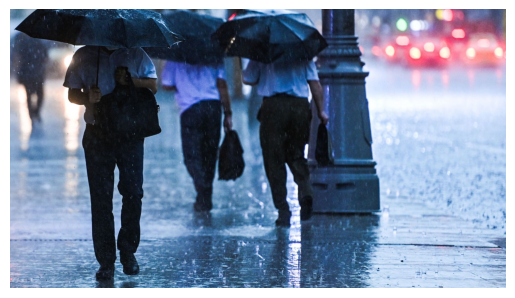

In [148]:
img = Image.open("../weather_recognition_pytorch_lightning/001.jpg")
plt.axis("off")
plt.imshow(img);

In [149]:
input = transform_test(img)

In [150]:
input.size()

torch.Size([3, 224, 224])

In [151]:
# преобразуем тензор в размер батча добавив еще одно измерение с 0 индексом
input.unsqueeze(0).size()

torch.Size([1, 3, 224, 224])

In [152]:
model.eval()
with torch.no_grad():
  out = model(input.unsqueeze(0).to(DEVICE))

In [153]:
out_vec = out.cpu().numpy()

In [154]:
idx = np.argmax(out_vec)
idx

6

In [155]:
dm.test_set.classes[idx]

'rain'

## Useful Links



- [pyTorch Lighning](https://www.pytorchlightning.ai/tutorials) - вспомогательная библиотка, которая помогает писать меньше кода для `pyTorch`
- [Albumentations](https://albumentations.ai/docs/) - одна из лучших библиотек для аугментаций
- [timm](https://github.com/rwightman/pytorch-image-models) - репозиторий зоопарка моделей `timm`
- [SOTA](https://paperswithcode.com/sota) - поиск решений State-of-the-Art
- [Обучение работы с captum](https://captum.ai/tutorials/Resnet_TorchVision_Interpret)


